In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import scipy.stats as stats
from scipy.stats import pearsonr
from tqdm import tqdm
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, f_classif
from scipy import sparse
from sklearn.decomposition import IncrementalPCA

In [24]:
df = pd.read_parquet('../data/dataframe_compressed.parquet')

In [28]:
df['TotalResponseTime'].value_counts().sort_values()

TotalResponseTime
1147.0      11
1178.0      11
1186.0      12
1183.0      12
1127.0      12
          ... 
266.0     6162
259.0     6174
265.0     6178
263.0     6180
275.0     6237
Name: count, Length: 1141, dtype: int64

In [25]:
df.head()

,DateTimeCall,TotalResponseTime,CellEastingNorthing100,CellEastingNorthing250,CellEastingNorthing500,CellEastingNorthing1000,CellEastingNorthing5000,CellEastingNorthing10000,DistanceStation,IncidentGroup_Fire,...,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,IsBankholiday,IsWeekend
IncidentNumber,,,,,,,,,,,,,,,,,,,,,
235138081,2009-01-01 00:02:27,319.0,528600-176800,528500-176750,528500-176500,528000-176000,525000-175000,520000-170000,1349.649309,0,...,0,0,0,0,0,0,0,0,1,0
2091,2009-01-01 00:04:09,308.0,533700-194400,533750-194250,533500-194000,533000-194000,530000-190000,530000-190000,635.731924,1,...,0,0,0,0,0,0,0,0,1,0
3091,2009-01-01 00:04:57,210.0,507700-182800,507750-182750,507500-182500,507000-182000,505000-180000,500000-180000,379.999487,1,...,0,0,0,0,0,0,0,0,1,0
5091,2009-01-01 00:06:04,233.0,531000-185300,531000-185250,531000-185000,531000-185000,530000-185000,530000-180000,1131.374466,1,...,0,0,0,0,0,0,0,0,1,0
6091,2009-01-01 00:06:30,172.0,529400-185200,529250-185250,529000-185000,529000-185000,525000-185000,520000-180000,534.359746,0,...,0,0,0,0,0,0,0,0,1,0


In [2]:
df_model = pd.read_parquet('C://Users/Isi/anaconda3/envs/FireBrigade/MAY24_BDS_INT_Fire_Brigade/data/df_cleaned_for_classification_models.parquet')

In [3]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1537704 entries, 235138081 to 067903-30042024
Columns: 320 entries, IncidentGroup_Fire to ResponseTimeBinary
dtypes: float64(7), int32(3), int64(310)
memory usage: 3.7+ GB


In [32]:
df_old = pd.read_csv('C://Users/Isi/anaconda3/envs/FireBrigade/Data/df_clean_before_NaNs_with_datetime_infos_with_geo.csv', index_col = 'IncidentNumber', dtype={'IncidentNumber': 'str'}, parse_dates=['DateTimeCall'])

In [70]:
# saving the datasets to files
df_model.to_parquet('C://Users/Isi/anaconda3/envs/FireBrigade/MAY24_BDS_INT_Fire_Brigade/data/df_cleaned_for_classification_models.parquet')
X_train.to_parquet('C://Users/Isi/anaconda3/envs/FireBrigade/MAY24_BDS_INT_Fire_Brigade/data/X_train_classification.parquet')
X_test.to_parquet('C://Users/Isi/anaconda3/envs/FireBrigade/MAY24_BDS_INT_Fire_Brigade/data/X_test_classification.parquet')

In [3]:
X = df_model.drop(['ResponseTimeBinary'], axis = 1)
y = df_model['ResponseTimeBinary']

In [7]:
# Baseline Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(solver='newton-cholesky', max_iter=10000)
model.fit(X_train, y_train)

y_train_pred1 = model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred1)
print(f'Training Accuracy: {train_accuracy:.2f}')

print('Training Classification Report:')
print(classification_report(y_train, y_train_pred1))

print('----------------------------------------------')


y_test_pred1 = model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred1)
print(f'Test Accuracy: {test_accuracy:.2f}')

print('Test Classification Report:')
print(classification_report(y_test, y_test_pred1))

Training Accuracy: 0.75
Training Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.29      0.40    361454
           1       0.76      0.94      0.84    868709

    accuracy                           0.75   1230163
   macro avg       0.71      0.61      0.62   1230163
weighted avg       0.73      0.75      0.71   1230163

----------------------------------------------
Test Accuracy: 0.75
Test Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.29      0.40     90243
           1       0.76      0.94      0.84    217298

    accuracy                           0.75    307541
   macro avg       0.71      0.61      0.62    307541
weighted avg       0.73      0.75      0.71    307541



In [8]:
# Model with PCA & Random Undersampling

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=0.85) 
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

rus = RandomUnderSampler(random_state=666)
X_train, y_train = rus.fit_resample(X_train, y_train)

model = LogisticRegression(solver='saga', max_iter=5000)
model.fit(X_train, y_train)

y_train_pred2 = model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred2)
print(f'Training Accuracy: {train_accuracy:.2f}')

print('Training Classification Report:')
print(classification_report(y_train, y_train_pred2))

print('----------------------------------------------')


y_test_pred2 = model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred2)
print(f'Test Accuracy: {test_accuracy:.2f}')

print('Test Classification Report:')
print(classification_report(y_test, y_test_pred2))

Training Accuracy: 0.66
Training Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.61      0.64    361454
           1       0.65      0.71      0.68    361454

    accuracy                           0.66    722908
   macro avg       0.66      0.66      0.66    722908
weighted avg       0.66      0.66      0.66    722908

----------------------------------------------
Test Accuracy: 0.68
Test Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.61      0.53     90243
           1       0.81      0.71      0.76    217298

    accuracy                           0.68    307541
   macro avg       0.64      0.66      0.64    307541
weighted avg       0.71      0.68      0.69    307541



In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=0.85) 
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

rus = RandomUnderSampler(random_state=666)
X_train, y_train = rus.fit_resample(X_train, y_train)

log_reg = LogisticRegression(max_iter=1000)

# Define parameter grid for Grid Search
param_grid = {
    'log_reg__C': [5, 10, 12, 15],  # Regularization strength
    'log_reg__penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Penalty type
    'log_reg__solver': ['lbfgs', 'saga', 'bilinear', 'sag']  # Solvers that support the penalties
}

pipeline = ImbPipeline([
    ('scaler', StandardScaler()),  # Including the scaler in the pipeline for consistency
    ('pca', PCA(n_components=0.85)),  # Including PCA in the pipeline for consistency
    ('undersampler', RandomUnderSampler(random_state=666)),  # Undersampling in the pipeline
    ('log_reg', log_reg)  # Logistic Regression
])

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='recall', n_jobs=-1)

# Fit GridSearchCV on the preprocessed training data
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)


C:\Users\Isi\anaconda3\envs\FireBrigade\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
144 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Isi\anaconda3\envs\FireBrigade\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Isi\anaconda3\envs\FireBrigade\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Isi\anaconda3\envs\FireBrigade\Lib\site-packages\imblea

Best parameters found:  {'log_reg__C': 5, 'log_reg__penalty': 'l2', 'log_reg__solver': 'lbfgs'}


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA to retain 85% of variance
pca = PCA(n_components=0.85)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Apply random undersampling
rus = RandomUnderSampler(random_state=666)
X_train, y_train = rus.fit_resample(X_train, y_train)

# Define the logistic regression model with the best parameters
best_log_reg = LogisticRegression(C=5, penalty='l2', solver='lbfgs', max_iter=10000)

# Create a pipeline with the best parameters
best_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),  # Including the scaler in the pipeline for consistency
    ('pca', PCA(n_components=0.85)),  # Including PCA in the pipeline for consistency
    ('undersampler', RandomUnderSampler(random_state=666)),  # Undersampling in the pipeline
    ('log_reg', best_log_reg)  # Logistic Regression with best parameters
])

# Fit the pipeline on the training data
best_pipeline.fit(X_train, y_train)

# Evaluate on training set
y_train_pred = best_pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy: {train_accuracy}")
print("Training set classification report:")
print(classification_report(y_train, y_train_pred))

# Evaluate on test set
y_test_pred = best_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy}")
print("Test set classification report:")
print(classification_report(y_test, y_test_pred))

Training accuracy: 0.6365972249126904
Training set classification report:
              precision    recall  f1-score   support

           0       0.66      0.56      0.61    361358
           1       0.62      0.71      0.66    361358

    accuracy                           0.64    722716
   macro avg       0.64      0.64      0.63    722716
weighted avg       0.64      0.64      0.63    722716

Test accuracy: 0.6684572138349033
Test set classification report:
              precision    recall  f1-score   support

           0       0.45      0.56      0.50     90339
           1       0.80      0.71      0.75    217202

    accuracy                           0.67    307541
   macro avg       0.62      0.64      0.63    307541
weighted avg       0.69      0.67      0.68    307541



In [50]:
# Model with PCA & RU & GridSearch

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=30) 
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

rus = RandomUnderSampler(random_state=666)
X_train, y_train = rus.fit_resample(X_train, y_train)

best_params = {'C': 0.01, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 5000}
final_model = LogisticRegression(**best_params)
final_model.fit(X_train, y_train)

y_train_pred3 = final_model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred3)
print(f'Training Accuracy: {train_accuracy:.2f}')

print('Training Classification Report:')
print(classification_report(y_train, y_train_pred3))

print('----------------------------------------------')

y_test_pred3 = final_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred3)
print(f'Test Accuracy: {test_accuracy:.2f}')

print('Test Classification Report:')
print(classification_report(y_test, y_test_pred3))

Training Accuracy: 0.65
Training Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.62      0.64    361454
           1       0.64      0.67      0.65    361454

    accuracy                           0.65    722908
   macro avg       0.65      0.65      0.65    722908
weighted avg       0.65      0.65      0.65    722908

----------------------------------------------
Test Accuracy: 0.66
Test Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.62      0.52     90243
           1       0.81      0.67      0.73    217298

    accuracy                           0.66    307541
   macro avg       0.63      0.65      0.63    307541
weighted avg       0.70      0.66      0.67    307541



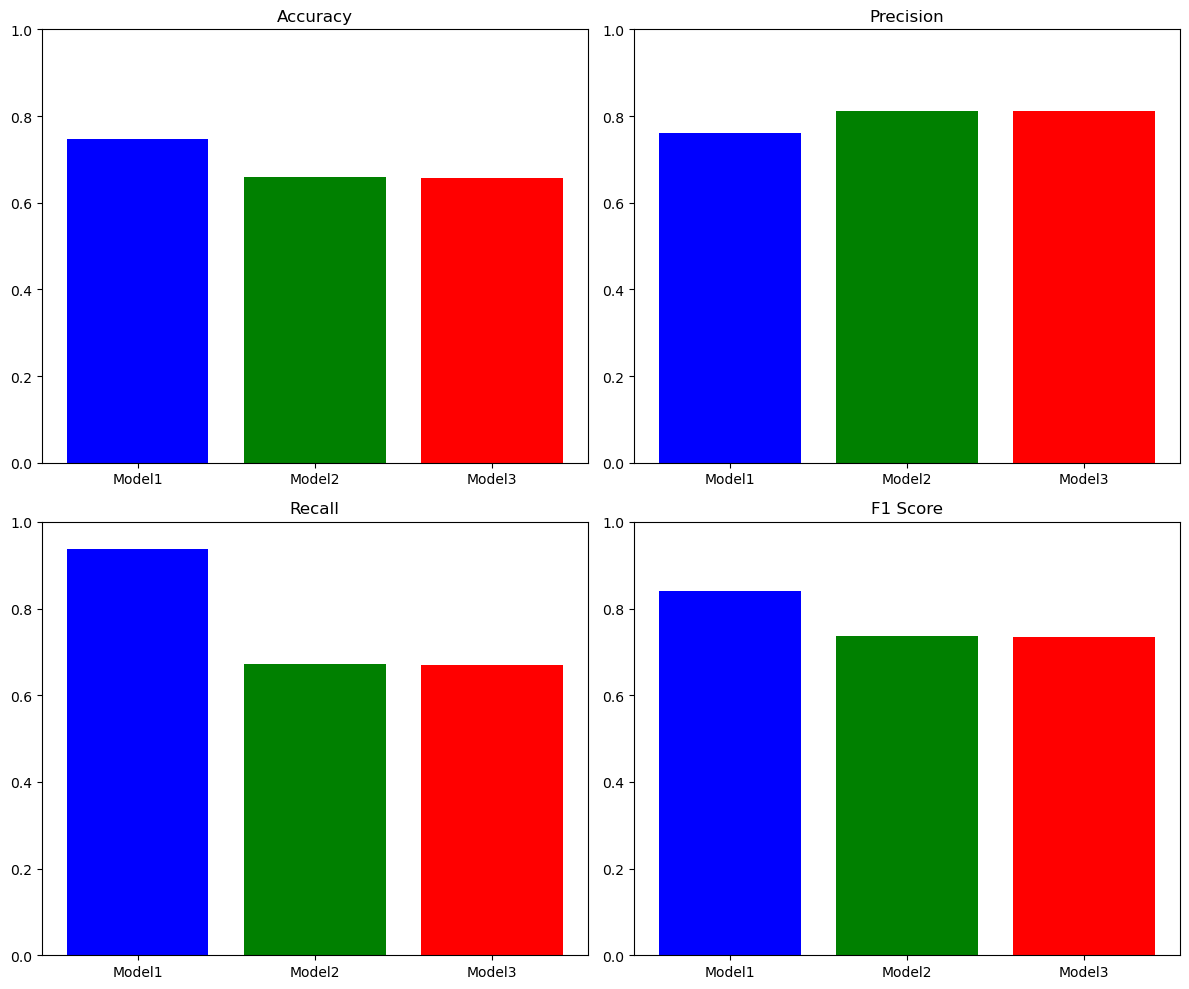

In [58]:
metrics = {
    'Model': ['Model1', 'Model2', 'Model3'],
    'Accuracy': [
        accuracy_score(y_test, y_test_pred1),
        accuracy_score(y_test, y_test_pred2),
        accuracy_score(y_test, y_test_pred3)
    ],
    'Precision': [
        precision_score(y_test, y_test_pred1),
        precision_score(y_test, y_test_pred2),
        precision_score(y_test, y_test_pred3)
    ],
    'Recall': [
        recall_score(y_test, y_test_pred1),
        recall_score(y_test, y_test_pred2),
        recall_score(y_test, y_test_pred3)
    ],
    'F1 Score': [
        f1_score(y_test, y_test_pred1),
        f1_score(y_test, y_test_pred2),
        f1_score(y_test, y_test_pred3)
    ]
}

# Convert metrics to DataFrame
import pandas as pd
metrics_df = pd.DataFrame(metrics)

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot Accuracy
ax[0, 0].bar(metrics_df['Model'], metrics_df['Accuracy'], color=['blue', 'green', 'red'])
ax[0, 0].set_title('Accuracy')
ax[0, 0].set_ylim([0, 1])

# Plot Precision
ax[0, 1].bar(metrics_df['Model'], metrics_df['Precision'], color=['blue', 'green', 'red'])
ax[0, 1].set_title('Precision')
ax[0, 1].set_ylim([0, 1])

# Plot Recall
ax[1, 0].bar(metrics_df['Model'], metrics_df['Recall'], color=['blue', 'green', 'red'])
ax[1, 0].set_title('Recall')
ax[1, 0].set_ylim([0, 1])

# Plot F1 Score
ax[1, 1].bar(metrics_df['Model'], metrics_df['F1 Score'], color=['blue', 'green', 'red'])
ax[1, 1].set_title('F1 Score')
ax[1, 1].set_ylim([0, 1])

# Adjust layout
plt.tight_layout()
plt.show()

# KNN

In [ ]:
# Baseline model (takes too long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=666)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit the baseline KNN classifier
knn_baseline = KNeighborsClassifier()
knn_baseline.fit(X_train, y_train)

# Evaluate on training set
y_train_pred1 = knn_baseline.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred1)
print(f"Training accuracy: {train_accuracy}")
print("Training set classification report:")
print(classification_report(y_train, y_train_pred1))

# Evaluate on test set
y_test_pred1 = knn_baseline.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred1)
print(f"Test accuracy: {test_accuracy}")
print("Test set classification report:")
print(classification_report(y_test, y_test_pred1))

In [4]:
# Baseline + PCA + RU

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=666, stratify=y)

# Define pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),  # Adjust the number of components as needed
    ('undersampler', RandomUnderSampler(random_state=666)),
    ('knn', KNeighborsClassifier())
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Evaluate on training set
y_train_pred = pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy: {train_accuracy}")
print("Training set classification report:")
print(classification_report(y_train, y_train_pred))

# Evaluate on test set
y_test_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy}")
print("Test set classification report:")
print(classification_report(y_test, y_test_pred))

Training accuracy: 0.7081881854107099
Training set classification report:
              precision    recall  f1-score   support

           0       0.50      0.74      0.60    271018
           1       0.87      0.69      0.77    651604

    accuracy                           0.71    922622
   macro avg       0.68      0.72      0.68    922622
weighted avg       0.76      0.71      0.72    922622

Test accuracy: 0.6373914372392624
Test set classification report:
              precision    recall  f1-score   support

           0       0.42      0.62      0.50    180679
           1       0.80      0.64      0.71    434403

    accuracy                           0.64    615082
   macro avg       0.61      0.63      0.61    615082
weighted avg       0.69      0.64      0.65    615082



In [10]:
# Baseline + PCA + Undersampling + GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=666)

pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('undersampler', RandomUnderSampler(random_state=666)),
    ('knn', KNeighborsClassifier())
])

# Define parameter grid
param_grid = {
    'pca__n_components': [5, 10],
    'knn__n_neighbors': [3, 5],
    'knn__weights': ['uniform', 'distance']
}

# Initialize and perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'knn__n_neighbors': 5, 'knn__weights': 'uniform', 'pca__n_components': 10}


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

best_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('pca', IncrementalPCA(n_components=18, batch_size=200)),
    ('undersampler', RandomUnderSampler(random_state=666)),
    ('knn', KNeighborsClassifier(n_neighbors=10, weights='uniform'))
])

best_pipeline.fit(X_train, y_train)

# Evaluate on training set
y_train_pred = best_pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy: {train_accuracy}")
print("Training set classification report:")
print(classification_report(y_train, y_train_pred))

# Evaluate on test set
y_test_pred = best_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy}")
print("Test set classification report:")
print(classification_report(y_test, y_test_pred))

Training accuracy: 0.6543880770271907
Training set classification report:
              precision    recall  f1-score   support

           0       0.45      0.76      0.56    361454
           1       0.86      0.61      0.71    868709

    accuracy                           0.65   1230163
   macro avg       0.65      0.68      0.64   1230163
weighted avg       0.74      0.65      0.67   1230163

Test accuracy: 0.611401406641716
Test set classification report:
              precision    recall  f1-score   support

           0       0.40      0.68      0.51     90243
           1       0.82      0.58      0.68    217298

    accuracy                           0.61    307541
   macro avg       0.61      0.63      0.59    307541
weighted avg       0.70      0.61      0.63    307541



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=666)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=0.85) 
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

rus = RandomUnderSampler(random_state=666)
X_train, y_train = rus.fit_resample(X_train, y_train)

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Testing different values for n_neighbors 'metric': ['euclidean', 'manhattan']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV on the preprocessed training data
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)